<a href="https://colab.research.google.com/github/ishaan27chaturvedi/Text-Classification/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECS 7001 - NN & NNLP**

## **2021/22 Lab 1: Skip-gram Model for Word2Vec**

<br>

**26th and 27th January**

There are two Word2Vec architectures for creating word embeddings: the Continuous Bag of Words (CBOW) architecture and the Skip Gram architecture . In this lab, we will obtain our own word embeddings by training a skip-gram neural network model. Some of the code for this will be supplied here but in some sections, you will be required to implement the code yourself. Hints and
tips will be provided.


The skip gram model is essentially a feedforward neural network with one hidden layer, trained to predict the context word given a target word. There are two ways to train this model: (1) using a hierarchical softmax function and/or (2) by negative sampling. In this lab, we will be training using
negative sampling. To train with negative sampling, the model is cast as a binary classification problem. The dataset would consist of positive and negative examples of the form:

Input | label
--| --
(target_word, word_in_its_context)       |  1 
(target_word, word_not_in_its_context)   |  0

created from the sentences in a corpus. The exact number of positive and negative examples will depend on the window size, and the balance ratio of positive:negative examples.  

As an example, consider the sentence: “ **The quick brown
fox jumped over the lazy dog** ”. For the target word ' **fox** ' and a window size of 2, all the positive and negative examples drawn from this sentence would be:

Input | label
--| --
(fox, the) | 0
(fox, quick) | 1
(fox, brown) | 1
(fox, jumped) | 1
(fox, over) |1
(fox, lazy) | 0
(fox, dog) | 0

The model is trained to learn to predict 1 when a word is in the context of the target word (i.e.in the window of the target word) and 0 otherwise. The model thus learns the statistics of the given corpus: the frequency with two words appear together would determine how similar they are (similarity is usually measured using cosine distance). After training, the trained hidden layer weights are the word embeddings.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Downloading the Corpus**

Our training data will be comprised of 3 documents from the Gutenberg corpus. We can find this and other corpora in nltk https://www.nltk.org/book/ch02.html

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('gutenberg')
import string
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


**Sanity check:**

This training corpus contains 16498 sentences. The following print statement should return 16498.

In [ ]:
print(len(austen))

16498


### **2. Preprocessing the Training Corpus**

In this section, you will write code to remove special characters, empty strings, digits and
stopwords from the sentences and put all the words into lower cases. You might also consider removing sentences with fewer than 3 words or at least empty sentences.


**Hints:**
*   The corpus can be accessed as you would a tokenized list, a list of lists, each inner list contains all the tokens in the sentence. Eg:
\>> austen[0] =['[', 'Sense', 'and', 'Sensibility', 'by','Jane', 'Austen', '1811', ']']

*   the python <string> library contains a variable “punctuation”, a string containing all
the special characters.

*   You might want to write a function that takes the corpus as an argument and returns the preprocessed corpus as a list of lists.

 Alternatively, you can use the keras preprocessing library to preprocess the text. More information on the library can be found here:
https://keras.io/preprocessing/text/


**Sanity check:**

After preprocessing the corpus, as a sanity check, print the following line of code. If you chose removed sentences of length with fewer than 3 words, it should be about 13651. 

As a test for your preprocessing function, preprocess the sample below and print the output of your function.

In [ ]:
def preprocess_corpus(corpus):
    '''
    Removes punctuations, numbers, empty strings, stop words and sentences with
    fewer than 3 words.
    '''
    stop_words = set(stopwords.words('english'))
    
    normalized_corpus = []
    for i in corpus:

      i = [s for s in i if s not in string.punctuation] 
      i = [a.translate(str.maketrans('', '', string.punctuation)) for a in i]
      i = [j for j in i if j.isalpha()]
      i = [c.strip() for c in i if len(c.strip()) != 0]
      i = [j.lower() for j in i]
      i = [j for j in i if j not in stop_words]

      if len(i) > 2: # lesser than 3 words
        normalized_corpus.append(i)

    return normalized_corpus

normalized_corpus = preprocess_corpus(austen)
print('The new length of the preprocessed output', len(normalized_corpus))

*In the preprocessing function, <br>
any words that are just punctuations are removed <br>
any words with punctuations attached are stripped <br>
any words that are numeric are removed <br>
any words that are empty are removed <br>
all stop words are removed <br>
all words are converted to lower case <br>
And any sentence that has fewer than 3 words are removed.*

In [ ]:
normalized_corpus[0]

['sense', 'sensibility', 'jane', 'austen']

In [ ]:
sample = austen[:2] + austen[100:102]
preprocessed_sample = preprocess_corpus(sample)


print(len(sample), sample)
print()
print(len(preprocessed_sample), preprocessed_sample)

4 [['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ['But', ',', 'then', ',', 'if', 'Mrs', '.', 'Dashwood', 'should', 'live', 'fifteen', 'years', 'we', 'shall', 'be', 'completely', 'taken', 'in', '."'], ['"', 'Fifteen', 'years', '!']]

2 [['sense', 'sensibility', 'jane', 'austen'], ['mrs', 'dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken']]


### **3. Creating the Corpus Vocabulary and Preparing the Data**


To prepare the data for machine learning, you will write code to prepare 3 variables:

1. \<word2idx>: a lookup table, a dictionary of (word index: word) pairs where **word index** is a unique integer assigned to every **unique word** in the corpus.
2. \<idx2word>: a dictionary of (token: token index), a reversal of \<word2idx>. 
3. \<sents_as_ids>: The input to the model cannot be text, rather, each word needs to be represented by a unique integer and each sentence an array of integers.


The incomplete code provided below is just a guide. 

In [ ]:
word2idx = {}

def prepareData(normalized_corpus):
    '''
    Creating IDs for all unique words
    Storing IDs in the dictionary word2idx
    Reverse storing words from IDs in dictionary in idx2words
    '''
    i = 0
    for sent in normalized_corpus:
        for word in sent:
            if word not in word2idx:
                word2idx[word] = i
                i+=1

    idx2word = {v: k for k, v in word2idx.items()}
    return word2idx, idx2word


def prepareSentsAsId(normalized_corpus):
    '''
    Converts every word in every sentence into an ID and returns sentence
    '''
    i = 0
    sents_as_ids = []
    for sent in normalized_corpus:
        ids = []
        for word in sent:
            ids.append(word2idx[word])
        sents_as_ids.append(ids)
    return sents_as_ids

In [ ]:
word2idx, idx2word = prepareData(normalized_corpus)
sents_as_ids =prepareSentsAsId(normalized_corpus)

**Sanity Check**

Copy and run the following lines of code:

```
print('Number of unique words:', len(word2idx)**
```
Returns a number between 9800 and 1200, the exact number depends on your preprocessing step. 

```
print('\nSample word2idx: ', list(word2idx.items())[:10])
```

Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('the', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]


```
print('\nSample idx2word:', list(idx2word.items())[:10])**
```

Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]

```
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))
```

Sample sents_as_id: [[0, 1, 2, 3], [41, 72, 6, 201, 619, 35, 620, 296, 621]]



In [ ]:
print('Number of unique words:', len(word2idx))
print('\nSample word2idx: ', list(word2idx.items())[:10])
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))

Number of unique words: 10096

Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('family', 4), ('dashwood', 5), ('long', 6), ('settled', 7), ('sussex', 8), ('estate', 9)]

Sample idx2word: [(0, 'sense'), (1, 'sensibility'), (2, 'jane'), (3, 'austen'), (4, 'family'), (5, 'dashwood'), (6, 'long'), (7, 'settled'), (8, 'sussex'), (9, 'estate')]

Sample sents_as_id: [[0, 1, 2, 3], [68, 5, 194, 592, 33, 593, 285, 594]]


After you have created the three variables, set the <vocab_size> and <embed_size> variables with the following commands:

In [ ]:
VOCAB_SIZE = len(word2idx) 
EMBED_SIZE = 100 # We are creating 100D embeddings.

### **4. Generating training instances**


In this section we would generate the training examples of the format shown in introduction using the keras skip-gram generator https://keras.io/preprocessing/sequence/ 

In [ ]:
from keras.preprocessing.sequence import skipgrams

skip_grams = []

for sent in sents_as_ids:
    skip_grams.append(skipgrams(sent, VOCAB_SIZE, window_size=2))

In [ ]:
skip_grams[0]

([[1, 3],
  [2, 2565],
  [2, 3],
  [1, 7417],
  [1, 6802],
  [3, 8382],
  [3, 1],
  [3, 2],
  [3, 7244],
  [2, 9183],
  [1, 2],
  [2, 1]],
 [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1])

*Created skipgrams from each sentence of the size 2
As you can see in the labels, we also have negative samples represented by 0s*

**Sanity Check:**

To view the skip_grams for the first sentence in the training data, run the line of code that follows. The output should look like:

(austen (3), sensibility (1)) -> 1

(austen (3), jane (2)) -> 1

(jane (2), sensibility (1)) -> 1

(jane (2), walked (2639)) -> 0

(jane (2), partridge (7948)) -> 0

(sensibility (1), austen (3)) -> 1

(sensibility (1), beneficial (5587)) -> 0

(sensibility (1), jane (2)) -> 1

(sensibility (1), dreamt (8308)) -> 0

(austen (3), perception (6543)) -> 0

(jane (2), austen (3)) -> 1

(austen (3), imposing (8622)) -> 0


In [ ]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

In [ ]:
for i in range(len(pairs)):
    print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
    # the first word and its index
    idx2word[pairs[i][0]], pairs[i][0],
    # the second word and its index
    idx2word[pairs[i][1]], pairs[i][1],
    # the label
    labels[i]))


(sensibility (1), austen (3)) -> 1
(jane (2), recollect (2565)) -> 0
(jane (2), austen (3)) -> 1
(sensibility (1), fearless (7417)) -> 0
(sensibility (1), knit (6802)) -> 0
(austen (3), enlivened (8382)) -> 0
(austen (3), sensibility (1)) -> 1
(austen (3), jane (2)) -> 1
(austen (3), scanty (7244)) -> 0
(jane (2), ships (9183)) -> 0
(sensibility (1), jane (2)) -> 1
(jane (2), sensibility (1)) -> 1


### **5. Building the Skip-gram Neural Network Architecture**

In this section we would be building the skip-gram neural network architecture using the Keras Functional API and the Sequential model introduced in the previous lab. https://keras.io/getting-started/functional-api-guide/ 

In [ ]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils.vis_utils import plot_model


The skip-gram model is two input one output feedforward neural network with one hidden layer and this will be built over a series of steps.

####**A. The first step is to initialize and transform the first input using the following lines of code:**

In [ ]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        embeddings_initializer='glorot_uniform',
                        input_length=1)(target_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((EMBED_SIZE, ))(target_embedding)

#### Target Word
*the model takes as input a matrix of shape (batch_size, input_length), <br>
computes an Embedding matrix of size (vocab_size (=10096) x embedding size (= 100)) <br>
and outputs a matrix of size (batch_size, input_length = 1, embedding size = 100)<br><br>
Number of trainable parameters = 10096 x 100 = 1009600*


####**B. Write similar code for the ‘context_word’ input.**

In [ ]:
# your code for the context_word goes here
# The input is an array of context indices e.g. [2, 45, 7, 23,...9]
context_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='context_embed_layer',
                        embeddings_initializer='glorot_uniform',
                        input_length=1)(context_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
context_input = Reshape((EMBED_SIZE, ))(context_embedding)

#### Context Word
*the model takes as input a matrix of shape (batch_size, input_length), <br>
computes an Embedding matrix of size (vocab_size (=10096) x embedding size (= 100)) <br>
and outputs a matrix of size (batch_size, input_length = 1, embedding size = 100)<br><br>
Number of trainable parameters = 10096 x 100 = 1009600*


####**C. Merge the inputs.**

Recall, each training instance is a (target_word, context_word) combination. Since we are trying to learn the degree of closeness between the two words, the model will compute the cosine distance between the two inputs using the <Dot> layer. https://keras.io/layers/merge/, hence fusing the two inputs into one.


In [ ]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

####**D. The Output Layer**

Pass the merged inputs (now a vector with a single number the cosine distance between the two input vectors for each word) into a sigmoid activated neuron. The output of this layer is the output of the model.

**Hint**: Use the <Dense> layer ( https://keras.io/layers/core/ ), with a ‘sigmoid’ activation function.

In [ ]:
# your code for the output layer goes here
from keras.layers import Activation

label = Activation('sigmoid')(merged_inputs)

####**E. Initialize the model:**

In [ ]:
# label is the output of step D.
model = Model(inputs=[target_word, context_word], outputs=[label])  

####**F. Compile the model using the <model.compile> command.** Use Loss = ‘mean_squared_error’, optimizer = ‘rmsprop’.

In [ ]:
# your code here
from keras import losses 
from keras import optimizers 
from keras import metrics 

model.compile(loss = 'mean_squared_error',  optimizer = 'rmsprop')

**Sanity check:**

Visualize the model and the model summary by running the following lines of code. 
view the model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 target_embed_layer (Embedding)  (None, 1, 100)      1009600     ['input_1[0][0]']                
                                                                                                  
 context_embed_layer (Embedding  (None, 1, 100)      1009600     ['input_2[0][0]']                
 )                                                                                            

####**G. Plot the model using ```vis utils```.**

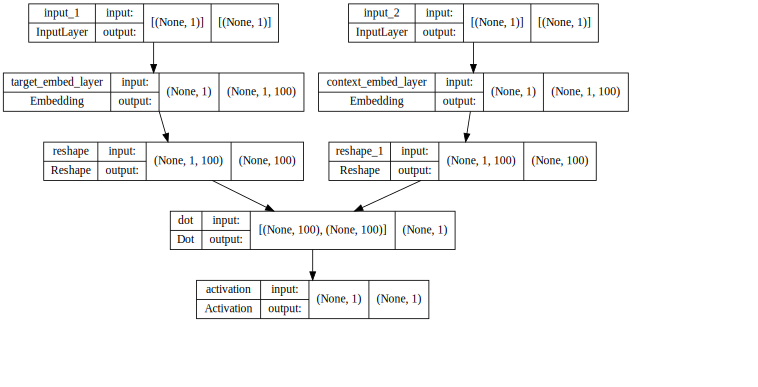

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
import pydot

SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

###**6.Training the Model**

Run the following block of code to train the model for 5 epochs:

In [ ]:
import numpy as np

NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: 
        	print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')


Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 1 Loss: 1403.9749394825194 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 2 Loss: 1360.0832106840098 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 3 Loss: 1317.3961265595572 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 4 Loss: 1276.9000476914953 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 5 Loss: 1238.3815406736685 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 6 Loss: 1201.949618566323 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 7 Loss: 1167.4385474708688 

Processed 0 sentences
Proces

The training takes about 10 minutes to run.

<br>

In the introduction, we outlined two approaches to training using the skipgram architecture. In this tutorial, we implemented the negative sampling training approach. While waiting for the training to complete, read this article http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/. It contains the skipgram model with softmax training. 

<br>

After reading the article, answer the following questions:  <br>
●	What would the inputs and outputs to the model be?<br>
*In this version of skipgram model with softmax training, the input is a one-hot encoded vector of the target words and the output is a probability distribution of the entire vocabulary that we get from the softmax function.*
<br>


●	How would you use the Keras framework to create this architecture?<br>
*In this model’s architecture, we have - 
Input layer - which takes one hot encoded vectors of the size (VOCAB_SIZE)
Hidden layer - a dense layer where the number of neurons would have to be tweaked based on trial and error. Google used 300 in their paper, so that's a good default.
Output layer - another dense layer with the softmax activation function of the length VOCAB_SIZE as we want a probability distribution of all the words
Loss function - MSE, Optimizer - Gradient Descent*

*input_layer = Input(shape = (len( VOCAB_SIZE ), )) 
hidden_dense_layer = Dense(300) (input_layer) 
output_layer = Dense(len( VOCAB_SIZE ), activation = 'softmax') (hidden_dense_layer)* 

*model = Model(inputs = input_layer, outputs = output_layer)*
<br>

●	What are the reasons this training approach is 
considered inefficient?<br>
*This training is inefficient for the following reasons:*
1.   *VOCAB_SIZE is 10096 and the number of features (hidden neurons) are 300. Therefore we have approximately 3 million weights that need to be trained. This is extremely costly in terms of computation.*
2. *This would also require a lot of data to train accurately*
3. *This model risks overfitting*
4. *The probability of choosing common words is much higher as compared to rarer words (negative sampling solves this).*








###**7. Getting the Word Embeddings**

The word embeddings are the weights of the target word embedding layer.


In [ ]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0] 

# should return (VOCAB_SIZE, EMBED_SIZE)
print(word_embeddings.shape)

(10096, 100)


Print out a few words and their embeddings using the next block of code. Your output may not be exactly as above but the command should print 10 words and their respective vectors.

In [ ]:
from pandas import DataFrame
df = DataFrame(word_embeddings, index=idx2word.values()).head(10)
print(df)

                   0         1         2         3         4         5   \
sense       -0.011637  0.009829  0.004087 -0.018591  0.018300 -0.018288   
sensibility  0.156813 -0.222918 -0.113573 -0.092008  0.031370 -0.205337   
jane        -0.223732  0.182885 -0.223252  0.369438  0.156197 -0.284776   
austen      -0.054637  0.094315  0.057830 -0.043763 -0.122583 -0.049328   
family      -0.055144  0.324346  0.062232 -0.593244  0.311688 -0.226881   
dashwood    -0.461433 -0.118336 -0.479978  0.092578  0.253852  0.498089   
long         0.243215 -0.407604  0.366762  0.020592  0.948889  0.355348   
settled      0.188509 -0.216111 -0.068561 -0.489369 -0.164512  0.127724   
sussex       0.050452  0.081146  0.010120 -0.093121 -0.053385 -0.094262   
estate      -0.007382  0.234132  0.011655 -0.309414 -0.148964 -0.077973   

                   6         7         8         9   ...        90        91  \
sense        0.017951  0.018204 -0.002979  0.020457  ...  0.012466  0.023935   
sensibility  0

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-0.017498,-0.003832,-0.037268,-0.115690,0.123085,0.002432,0.201249,0.033630,-0.016353,0.092066,...,-0.062111,-0.106095,-0.095107,0.019273,0.139043,0.098356,0.033508,0.138206,-0.298175,-0.034027
std,0.207620,0.232244,0.217541,0.282487,0.333888,0.254534,0.293890,0.335754,0.255100,0.232103,...,0.129941,0.282839,0.138428,0.224498,0.141285,0.398450,0.237583,0.307591,0.383094,0.270619
min,-0.461433,-0.407604,-0.479978,-0.593244,-0.164512,-0.284776,-0.099769,-0.444805,-0.413706,-0.295745,...,-0.331953,-0.700103,-0.393311,-0.397902,-0.070377,-0.205165,-0.451417,-0.446143,-1.105534,-0.595834
25%,-0.055017,-0.191667,-0.102320,-0.255341,-0.105284,-0.177568,0.028289,-0.084962,-0.232095,-0.035638,...,-0.115747,-0.237516,-0.134130,-0.039385,0.025452,-0.157324,-0.076246,0.009023,-0.447359,-0.132976
50%,-0.009509,0.045487,0.007103,-0.067886,0.024835,-0.063651,0.066292,-0.009323,0.002317,0.073604,...,-0.066779,-0.053304,-0.105743,0.058088,0.170687,-0.035723,0.065189,0.135285,-0.217423,-0.001021
75%,0.130223,0.160743,0.046287,0.010796,0.229438,0.091221,0.236519,0.070455,0.211473,0.237755,...,0.005696,0.072653,-0.001129,0.168857,0.203486,0.114808,0.204222,0.232858,-0.002560,0.151372
max,0.243215,0.324346,0.366762,0.369438,0.948889,0.498089,0.793854,0.865530,0.265528,0.421511,...,0.126633,0.258016,0.089915,0.332944,0.353992,1.089846,0.337087,0.708458,0.139547,0.284515


###**8.  Measuring Similarity Between Word Pairs**



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_embeddings)

# should print(VOCAB_SIZE, VOCAB_SIZE)
print(similarity_matrix.shape)   

(10096, 10096)


In [ ]:
similarity_matrix

array([[ 1.0000001 , -0.0823239 ,  0.02126353, ...,  0.04913739,
        -0.05976533,  0.00956694],
       [-0.0823239 ,  0.99999994,  0.21402985, ...,  0.09846736,
         0.05819568,  0.1872377 ],
       [ 0.02126353,  0.21402985,  1.0000001 , ..., -0.07359308,
        -0.1523364 ,  0.03511007],
       ...,
       [ 0.04913739,  0.09846736, -0.07359308, ...,  1.0000001 ,
        -0.04602234, -0.03006206],
       [-0.05976533,  0.05819568, -0.1523364 , ..., -0.04602234,
         1.        ,  0.00831366],
       [ 0.00956694,  0.1872377 ,  0.03511007, ..., -0.03006206,
         0.00831366,  0.9999999 ]], dtype=float32)

## Visualizing Similarity Matrix

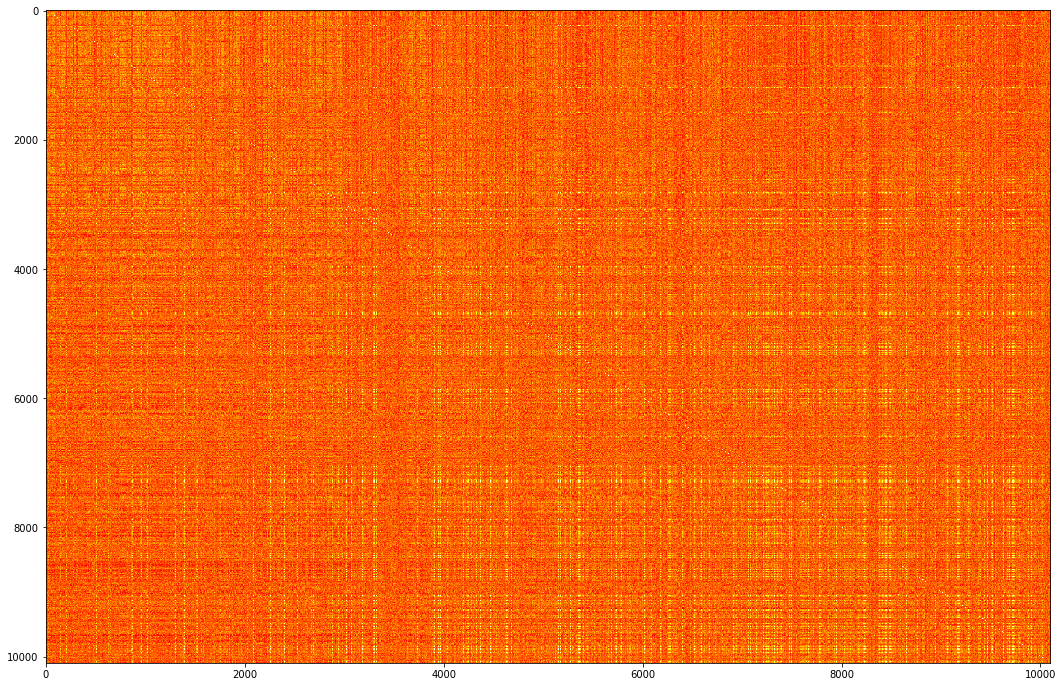

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 12))
ax.imshow(similarity_matrix, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

###**9. Exploring and Visualizing your Word Embeddings using t-SNE**

**A.	Get the most similar words to the search items in the list below**

search_terms = ['family', 'love', 'equality', 'wisdom', 'justice',  'humour', 'rejection']


**Sanity check:**
The similar words obtained would depend on your training but the above command should print a dictionary. Each key is a search term and each value is a list of the 5 words the model predicts to be most similar to the key word. 


In [ ]:
search_terms = ['think', 'thought', 'mr', 'friend', 'love', 'disdain']

# write code to get the 5 words most similar to the words in search_terms
similar_words = {}

for search_term in search_terms:
  ind = np.argpartition(similarity_matrix[word2idx[search_term]], -5)[-6:-1]
  similar_words[search_term] = [idx2word[val] for val in ind]

print(similar_words)

{'think': ['title', 'affected', 'declare', 'meanwhile', 'impossible'], 'thought': ['italian', 'law', 'sight', 'consequence', 'exultation'], 'mr': ['larkins', 'dictate', 'perry', 'mr', 'suspected'], 'friend': ['design', 'byron', 'barouche', 'hey', 'excessively'], 'love': ['permitted', 'amiable', 'direct', 'rich', 'love'], 'disdain': ['forgiveness', 'recital', 'essential', 'disdain', 'self']}


**B. Plot the words in the dictionary above using t-SN**E 

https://lvdmaaten.github.io/tsne/ 

Plot 50 of the word embeddings using the code snippets below:














/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


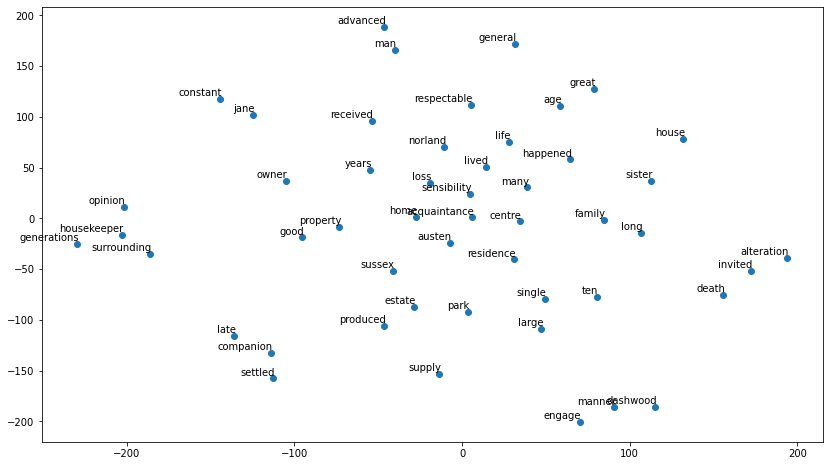

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50 

T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        



**10. Resources used**

http://jalammar.github.io/illustrated-word2vec/
https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ 
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa 
https://adventuresinmachinelearning.com/word2vec-keras-tutorial/ 
https://www.tensorflow.org/tutorials/representation/word2vec#the_skip-gram_model 
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py 

